In [1]:
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pickle
import torch.nn.functional as F
from transformer_lens import HookedTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)


In [2]:
#Load model

device = "cuda" if torch.cuda.is_available() else "cpu"
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
#Function to get top tokens from a prompt

def get_top_predictions(prompt, top_k=10):
    """Get top k predicted tokens after a prompt."""
    input_tokens = model.to_tokens(prompt, prepend_bos=True)
    logits = model(input_tokens)
    probs = logits.softmax(dim=-1)
    
    # Get predictions for the last position
    index = len(input_tokens[0])
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)
    
    return [(model.to_string(sorted_token_positions[0, i]), 
             sorted_token_probs[0, i].item()) 
            for i in range(top_k)]

In [4]:
def get_top_unigrams(prompt="<|endoftext|>", top_k=10):
    #print(f"Finding top {top_k} unigrams for prompt: {prompt}")
    top_unigrams = []
    embeddings = {}
    
    predictions = get_top_predictions(prompt, top_k=top_k)  # Pass parameters to get_top_predictions
    for token, prob in predictions:
        print(f"Token: |{token}| Probability: {prob:.2%}")
        top_unigrams.append(token)
        
        # Get embedding for this unigram
        tokens = model.to_tokens(token, prepend_bos=True)
        _, cache = model.run_with_cache(tokens)
        embedding = cache["blocks.8.hook_resid_post"][:, -1, :]
        embeddings[token] = embedding

    return top_unigrams, embeddings

In [5]:
#Function to get embeddings
def get_embedding(word, layer):
    tokens = model.to_tokens(word, prepend_bos=True)
    _, cache = model.run_with_cache(tokens)
    
    embedding = cache["blocks." + str(layer) +".hook_resid_post"][:, -1, :]
    return embedding

In [9]:
def visualize_unigram_similarities(unigrams, similarities):
    n = len(unigrams)
    cosine_matrix = np.zeros((n, n))
    euclidean_matrix = np.zeros((n, n))
    manhattan_matrix = np.zeros((n, n))
    
    for i, word1 in enumerate(unigrams):
        for j, word2 in enumerate(unigrams):
            cosine_matrix[i,j] = similarities[(word1, word2)]['cosine']
            euclidean_matrix[i,j] = similarities[(word1, word2)]['euclidean']
            manhattan_matrix[i,j] = similarities[(word1, word2)]['manhattan']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.heatmap(cosine_matrix, xticklabels=unigrams, yticklabels=unigrams,
                cmap='viridis', annot=True, fmt='.2f', ax=ax1)
    ax1.set_title('Unigram-Unigram Cosine Similarity')
    
    sns.heatmap(euclidean_matrix, xticklabels=unigrams, yticklabels=unigrams,
                cmap='viridis', annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Unigram-Unigram Euclidean Distance')
    
    sns.heatmap(manhattan_matrix, xticklabels=unigrams, yticklabels=unigrams,
                cmap='viridis', annot=True, fmt='.2f', ax=ax3)
    ax3.set_title('Unigram-Unigram Manhattan Distance')
    
    plt.tight_layout()
    plt.show()

In [10]:
# For unigram-bigram similarities
def visualize_unigram_bigram_similarities(results):
    unigrams = results['unigrams']
    bigram_dict = results['bigram_dict']
    similarities = results['unigram_bigram_similarities']
    
    # Create matrices for each metric
    # Rows are unigrams, columns are bigrams
    n_unigrams = len(unigrams)
    n_bigrams_per_unigram = len(bigram_dict[unigrams[0]])  # assuming same number for each
    
    cosine_matrix = np.zeros((n_unigrams, n_bigrams_per_unigram))
    euclidean_matrix = np.zeros((n_unigrams, n_bigrams_per_unigram))
    manhattan_matrix = np.zeros((n_unigrams, n_bigrams_per_unigram))
    
    for i, unigram in enumerate(unigrams):
        bigrams = [bigram for bigram, _ in bigram_dict[unigram]]
        for j, bigram in enumerate(bigrams):
            cosine_matrix[i,j] = similarities[(unigram, bigram)]['cosine']
            euclidean_matrix[i,j] = similarities[(unigram, bigram)]['euclidean']
            manhattan_matrix[i,j] = similarities[(unigram, bigram)]['manhattan']
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    
    sns.heatmap(cosine_matrix, xticklabels=[b for b, _ in bigram_dict[unigrams[0]]], 
                yticklabels=unigrams, cmap='viridis', annot=True, fmt='.2f', ax=ax1)
    ax1.set_title('Unigram-Bigram Cosine Similarity')
    plt.xticks(rotation=45)
    
    sns.heatmap(euclidean_matrix, xticklabels=[b for b, _ in bigram_dict[unigrams[0]]], 
                yticklabels=unigrams, cmap='viridis', annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Unigram-Bigram Euclidean Distance')
    plt.xticks(rotation=45)
    
    sns.heatmap(manhattan_matrix, xticklabels=[b for b, _ in bigram_dict[unigrams[0]]], 
                yticklabels=unigrams, cmap='viridis', annot=True, fmt='.2f', ax=ax3)
    ax3.set_title('Unigram-Bigram Manhattan Distance')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [11]:
# For bigram-bigram similarities (for each unigram)
def visualize_bigram_similarities(results):
    for unigram in results['unigrams']:
        bigrams = [bigram for bigram, _ in results['bigram_dict'][unigram]]
        n = len(bigrams)
        
        cosine_matrix = np.zeros((n, n))
        euclidean_matrix = np.zeros((n, n))
        manhattan_matrix = np.zeros((n, n))
        
        for i, bigram1 in enumerate(bigrams):
            for j, bigram2 in enumerate(bigrams):
                cosine_matrix[i,j] = results['bigram_similarities'][(bigram1, bigram2)]['cosine']
                euclidean_matrix[i,j] = results['bigram_similarities'][(bigram1, bigram2)]['euclidean']
                manhattan_matrix[i,j] = results['bigram_similarities'][(bigram1, bigram2)]['manhattan']
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        plt.suptitle(f'Bigram Similarities for Unigram: {unigram}')
        
        sns.heatmap(cosine_matrix, xticklabels=bigrams, yticklabels=bigrams,
                    cmap='viridis', annot=True, fmt='.2f', ax=ax1)
        ax1.set_title('Bigram-Bigram Cosine Similarity')
        plt.xticks(rotation=45)
        
        sns.heatmap(euclidean_matrix, xticklabels=bigrams, yticklabels=bigrams,
                    cmap='viridis', annot=True, fmt='.2f', ax=ax2)
        ax2.set_title('Bigram-Bigram Euclidean Distance')
        plt.xticks(rotation=45)
        
        sns.heatmap(manhattan_matrix, xticklabels=bigrams, yticklabels=bigrams,
                    cmap='viridis', annot=True, fmt='.2f', ax=ax3)
        ax3.set_title('Bigram-Bigram Manhattan Distance')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()



Getting top unigrams...

Getting bigrams for each unigram...


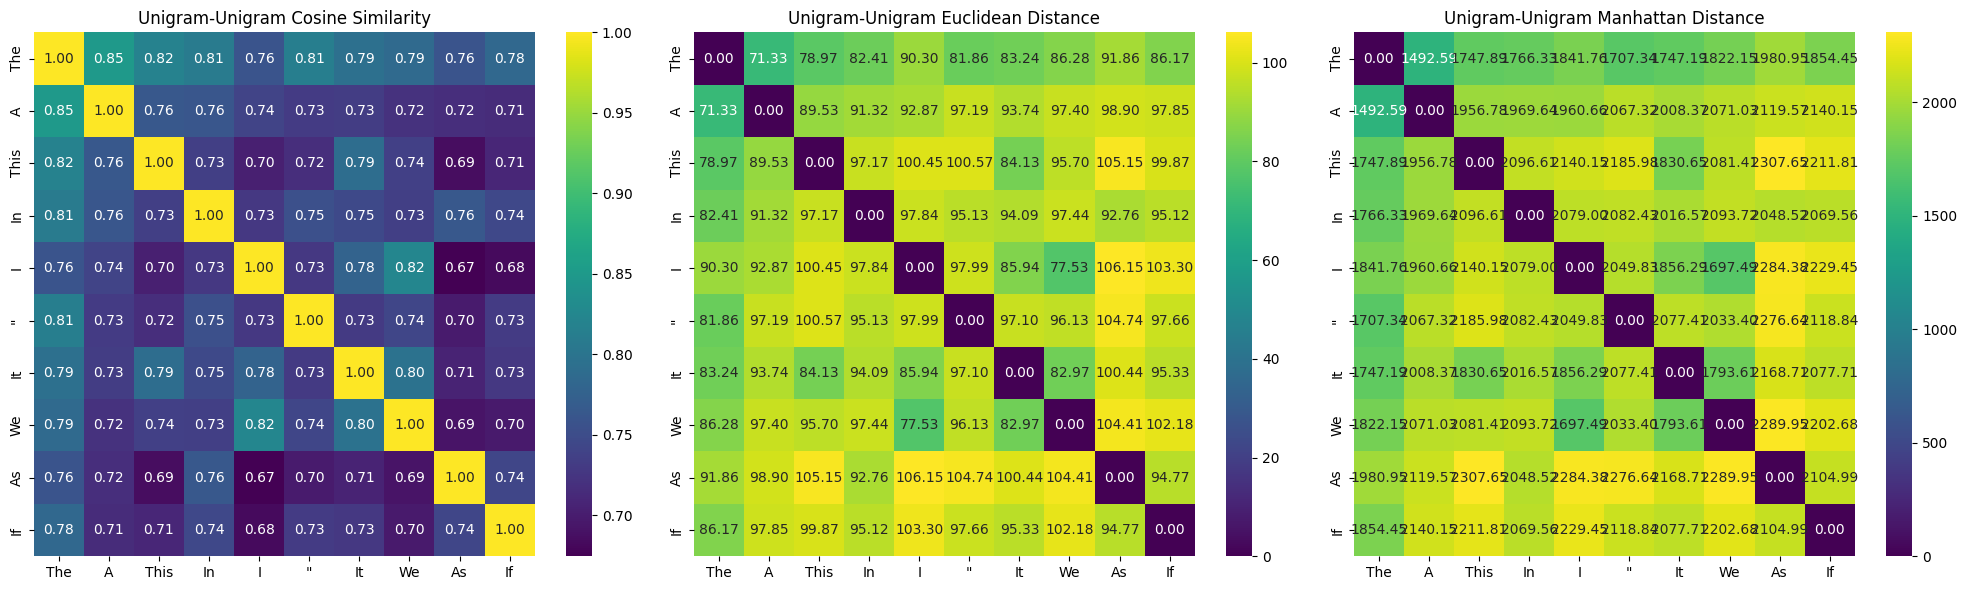

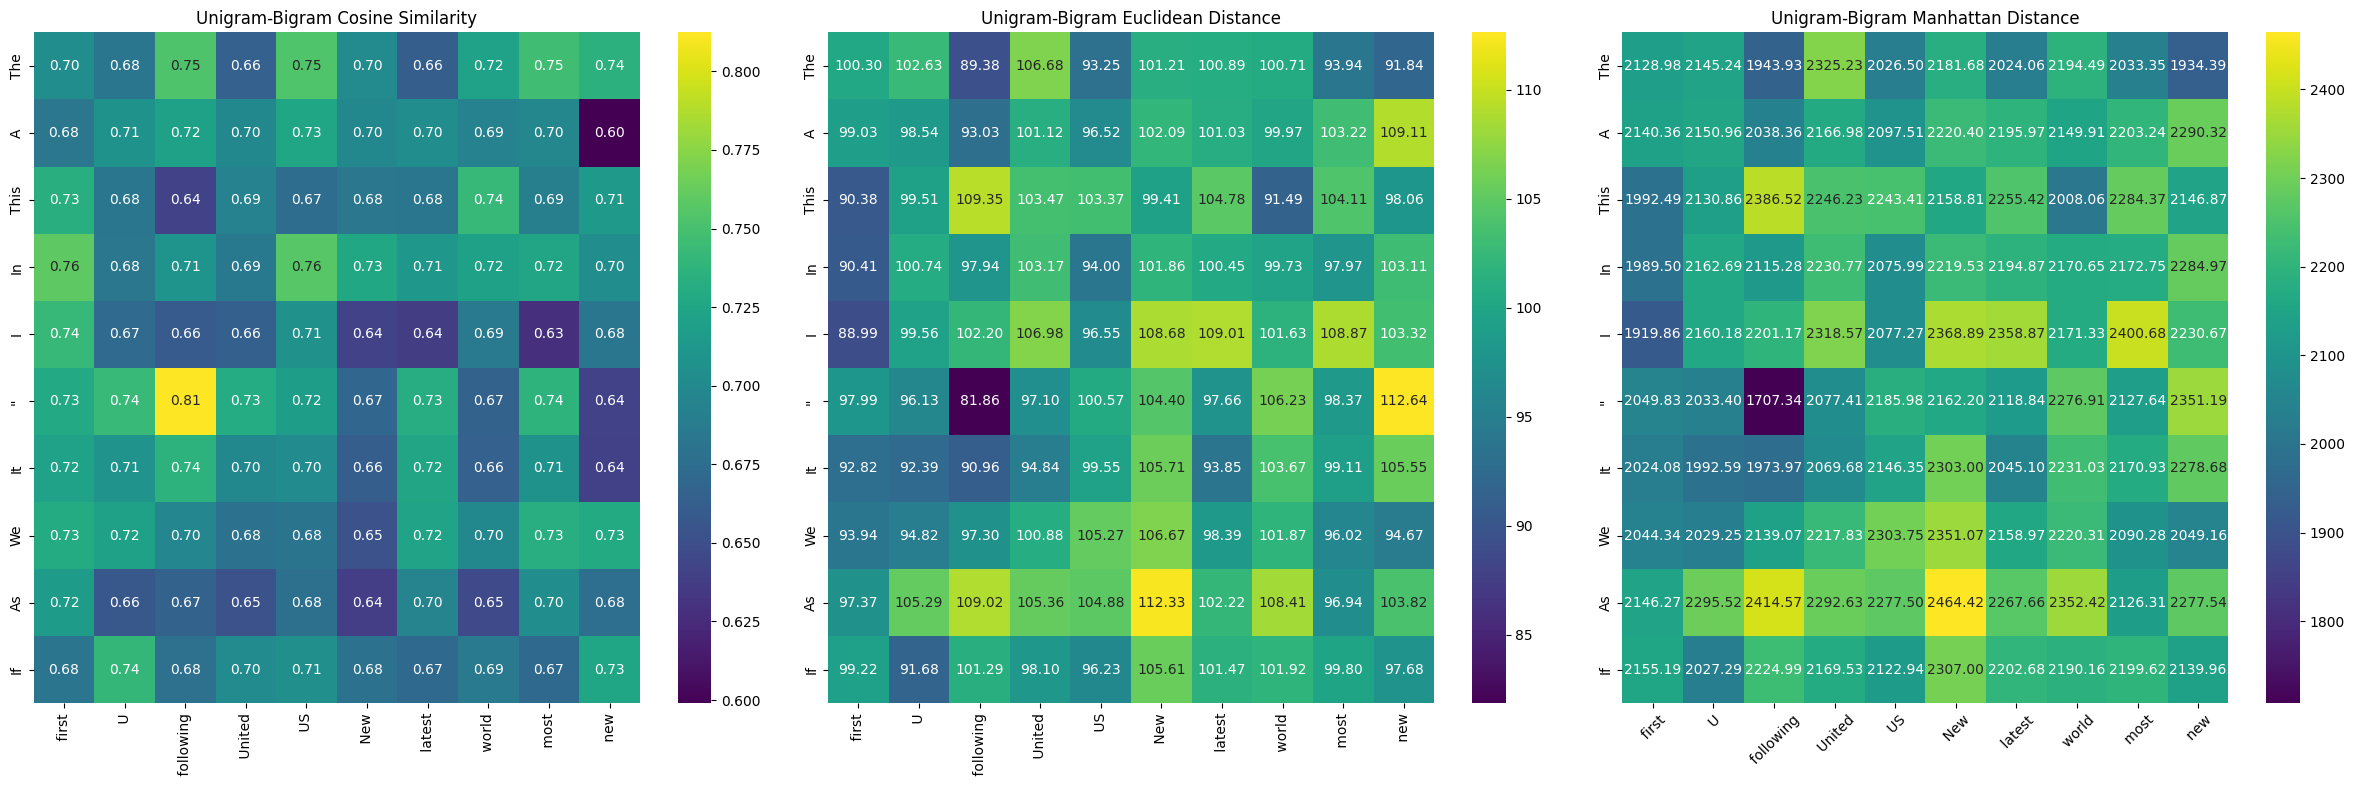

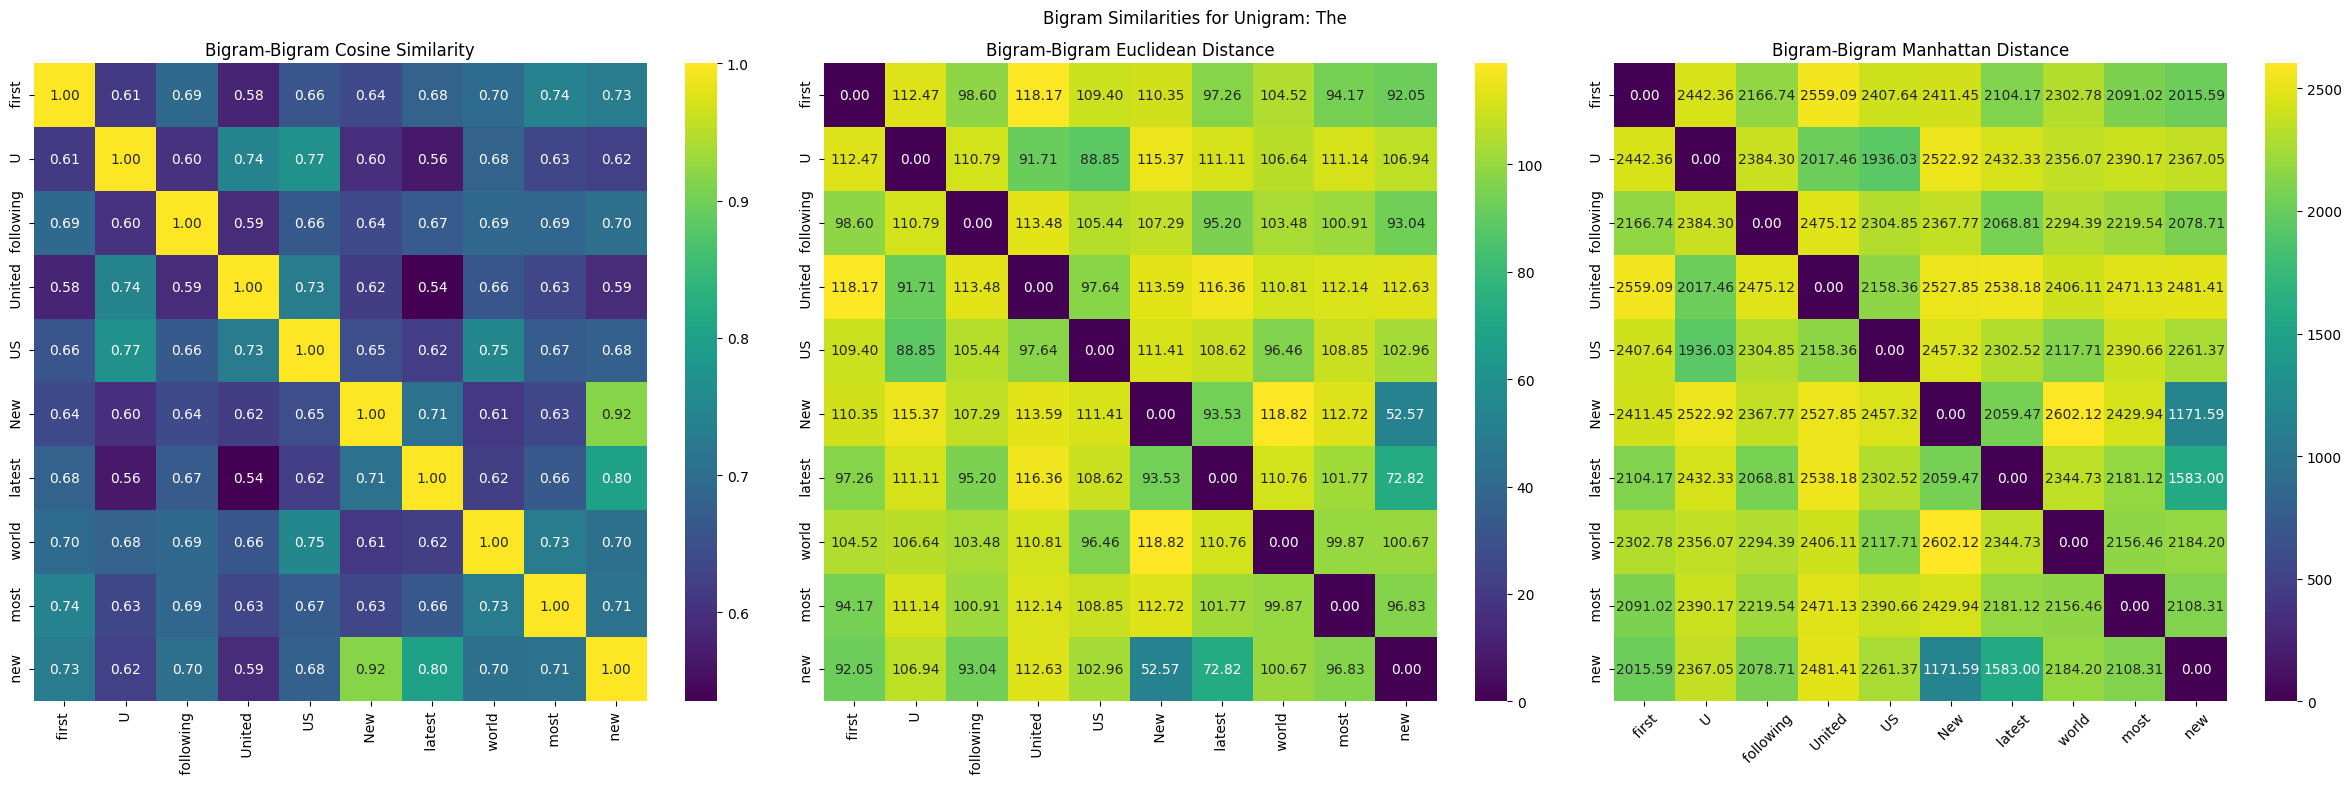

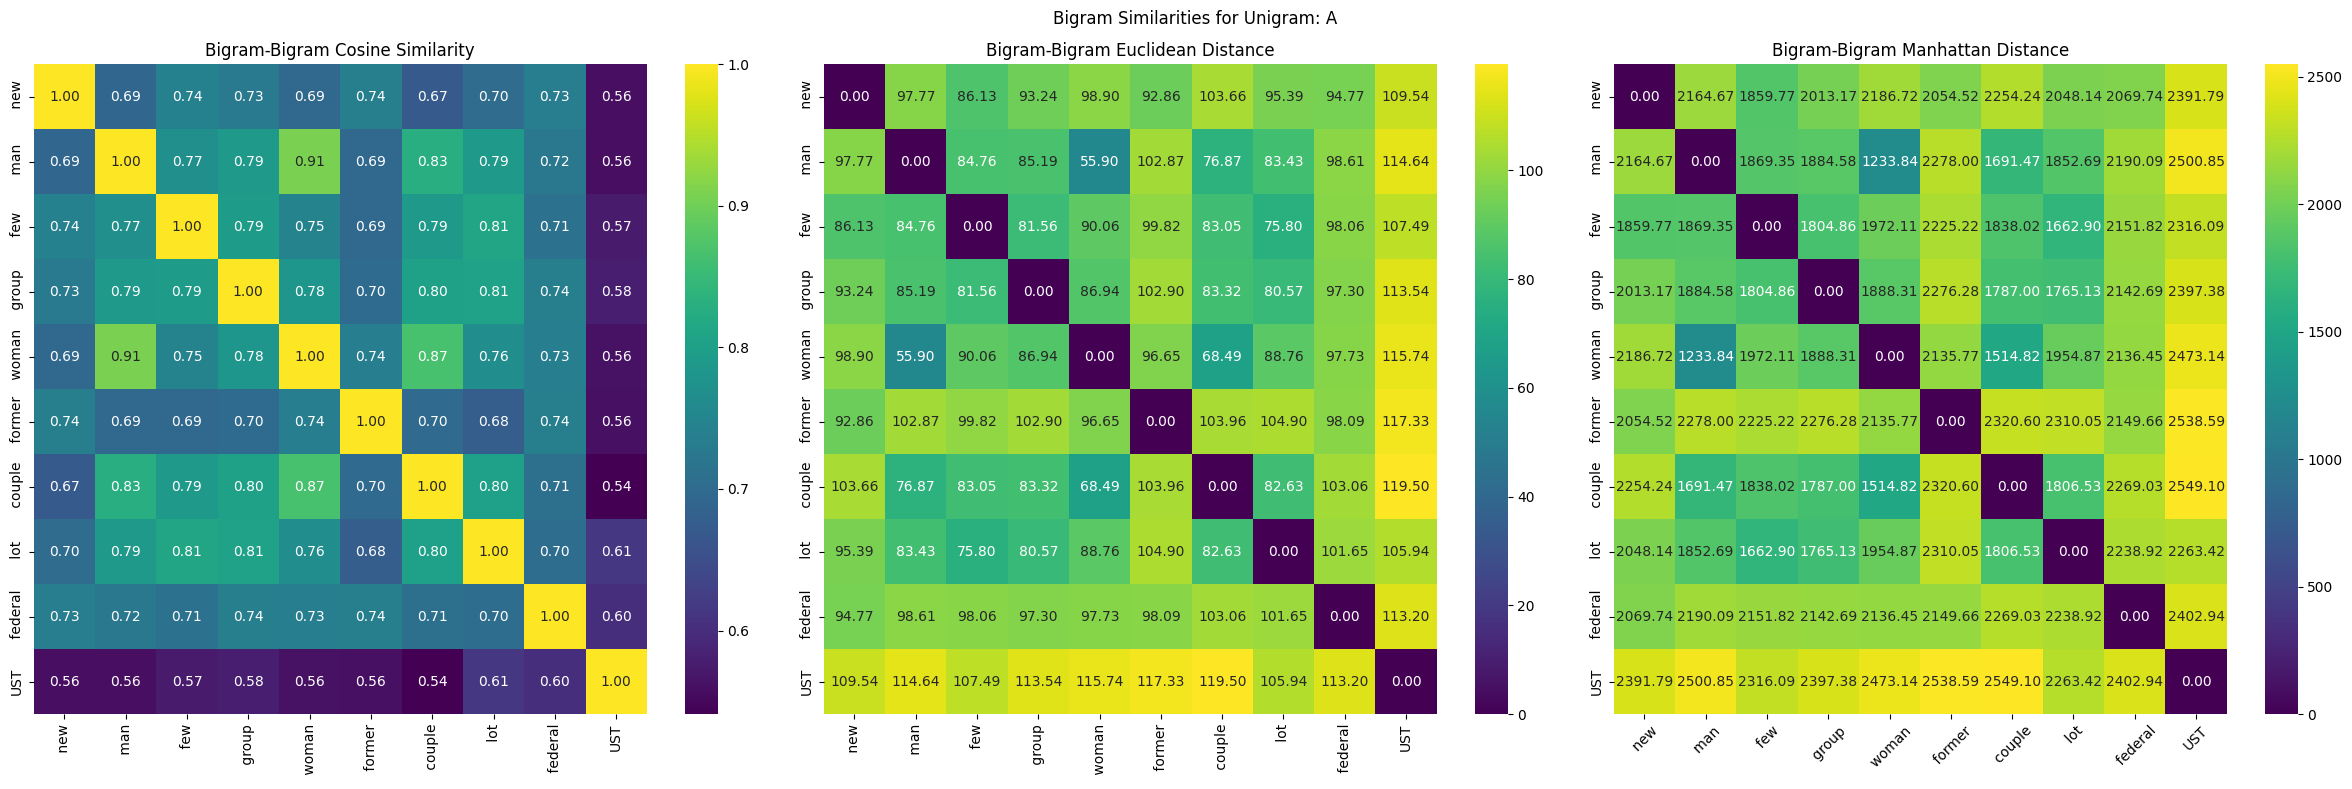

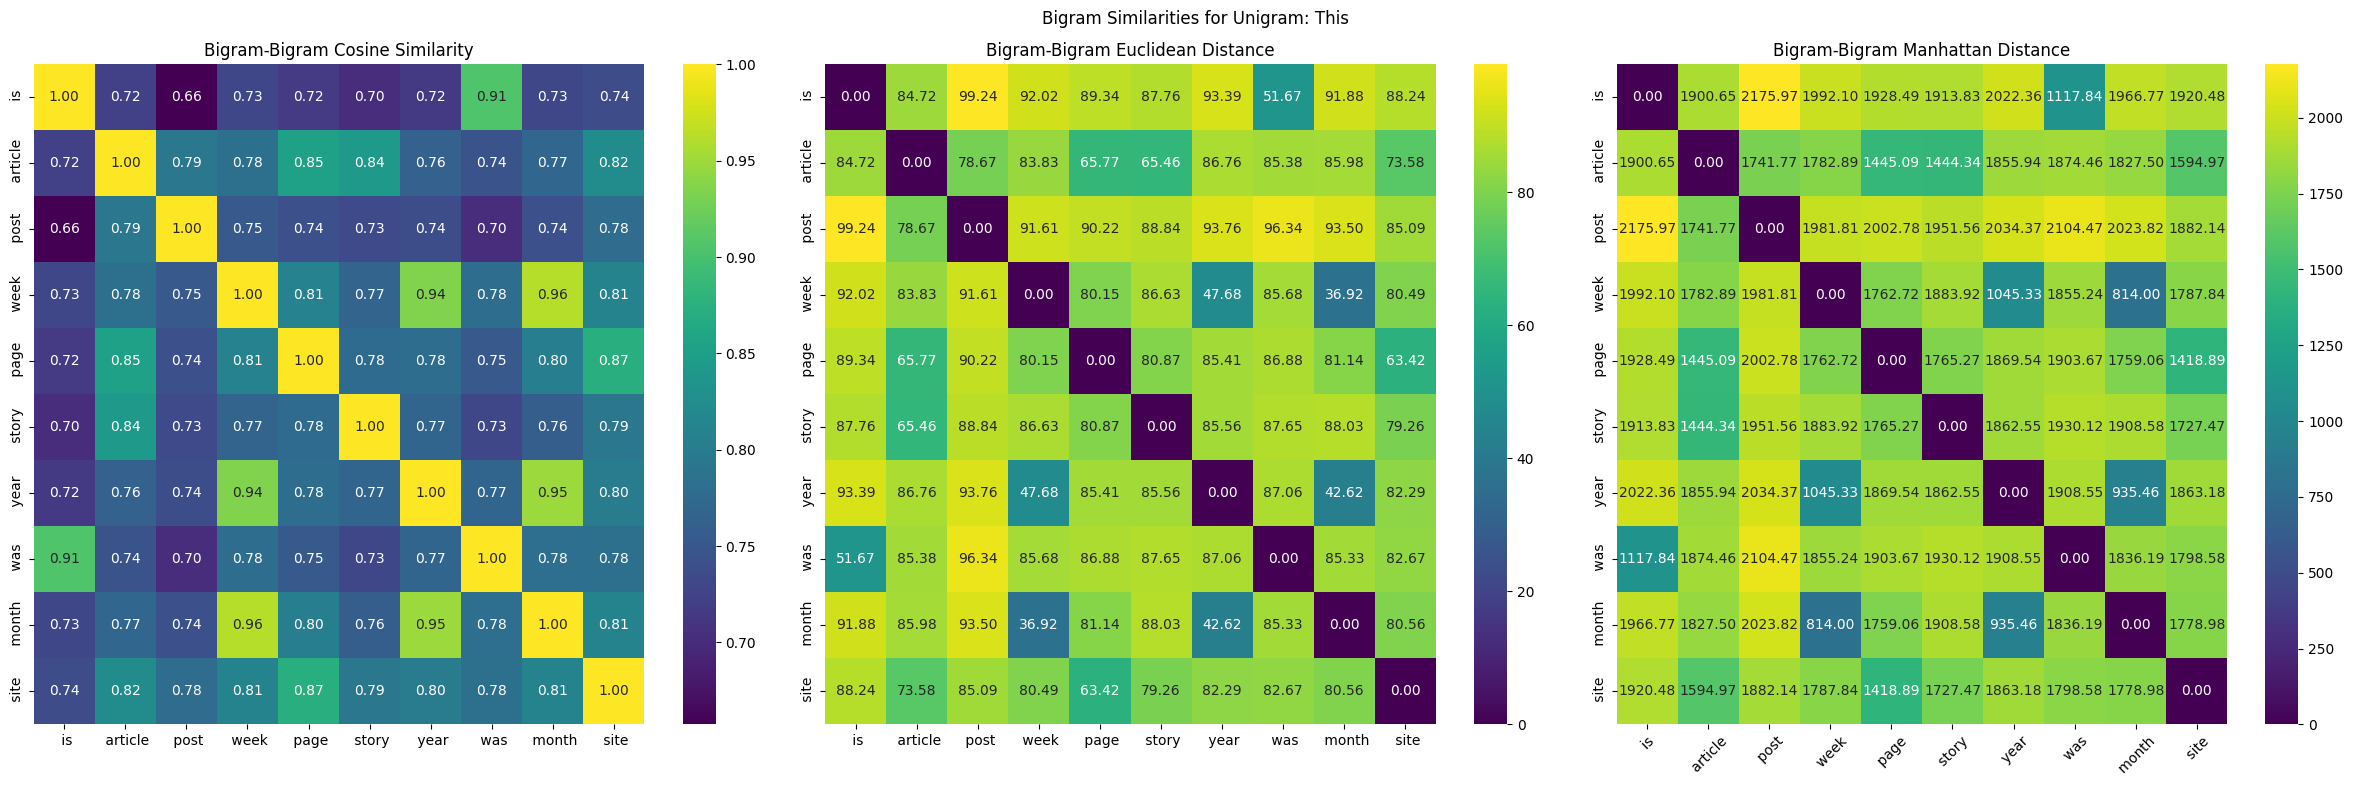

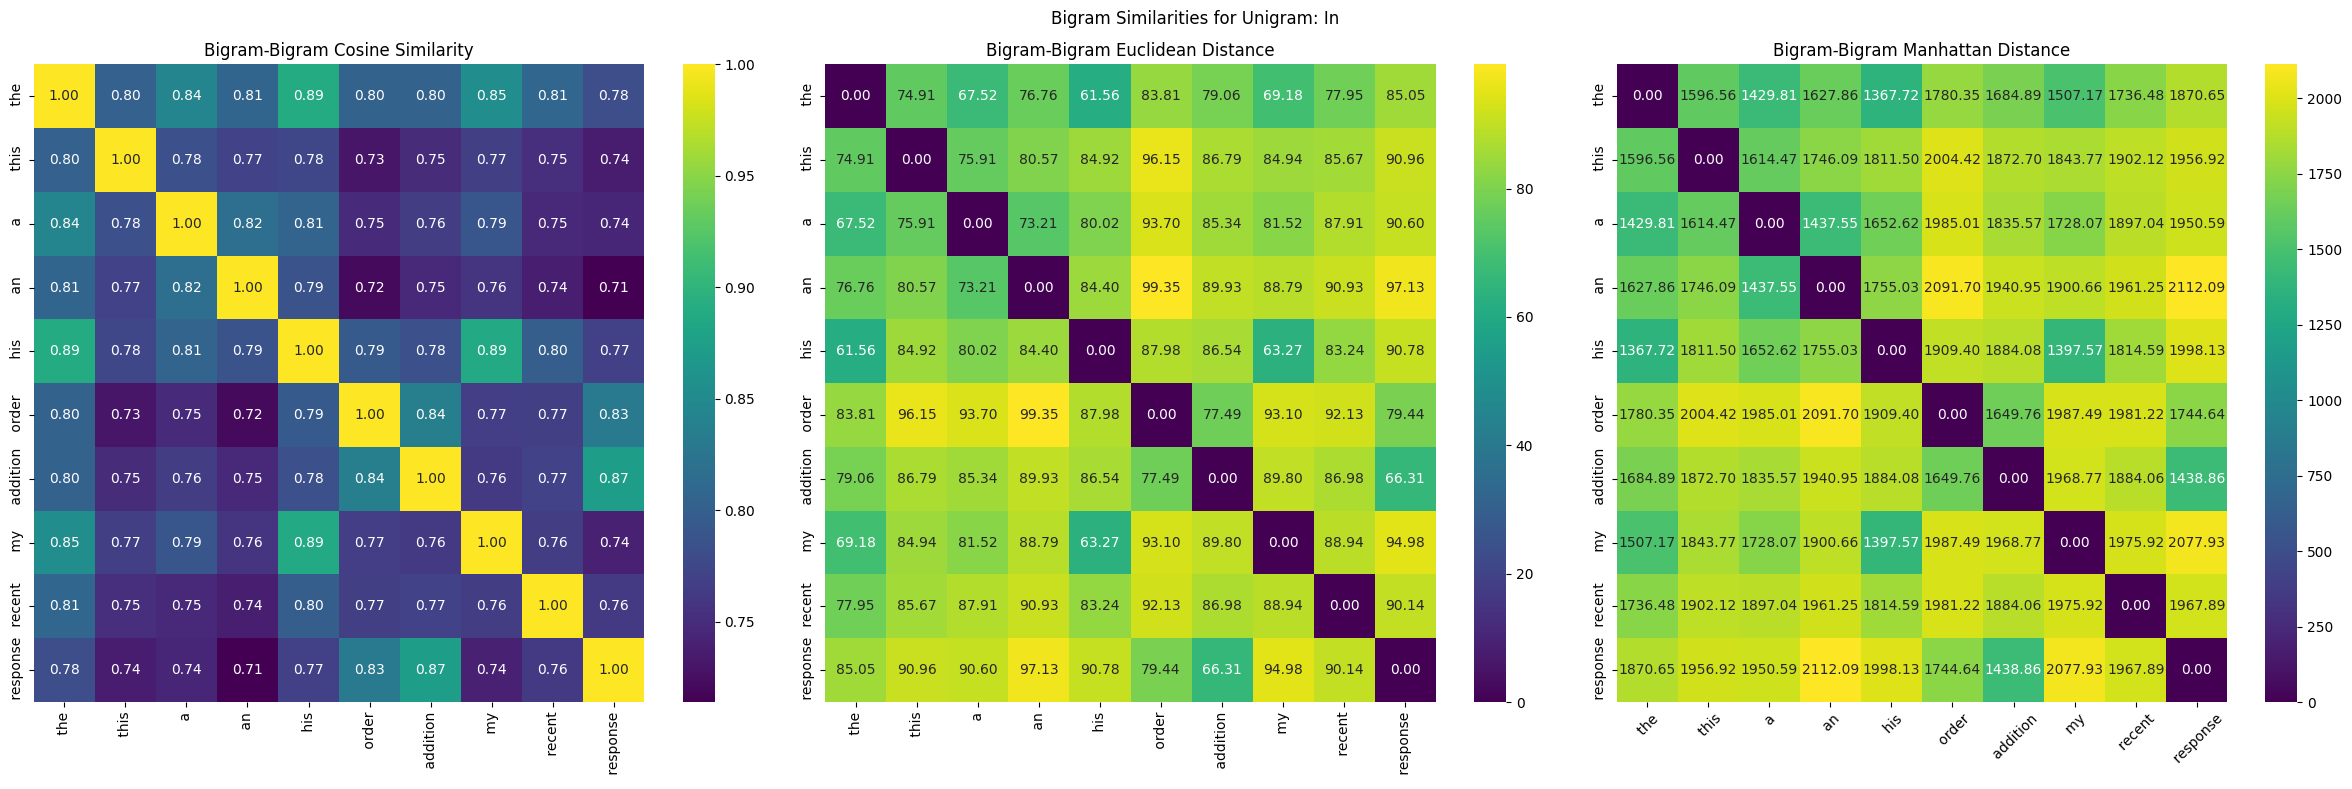

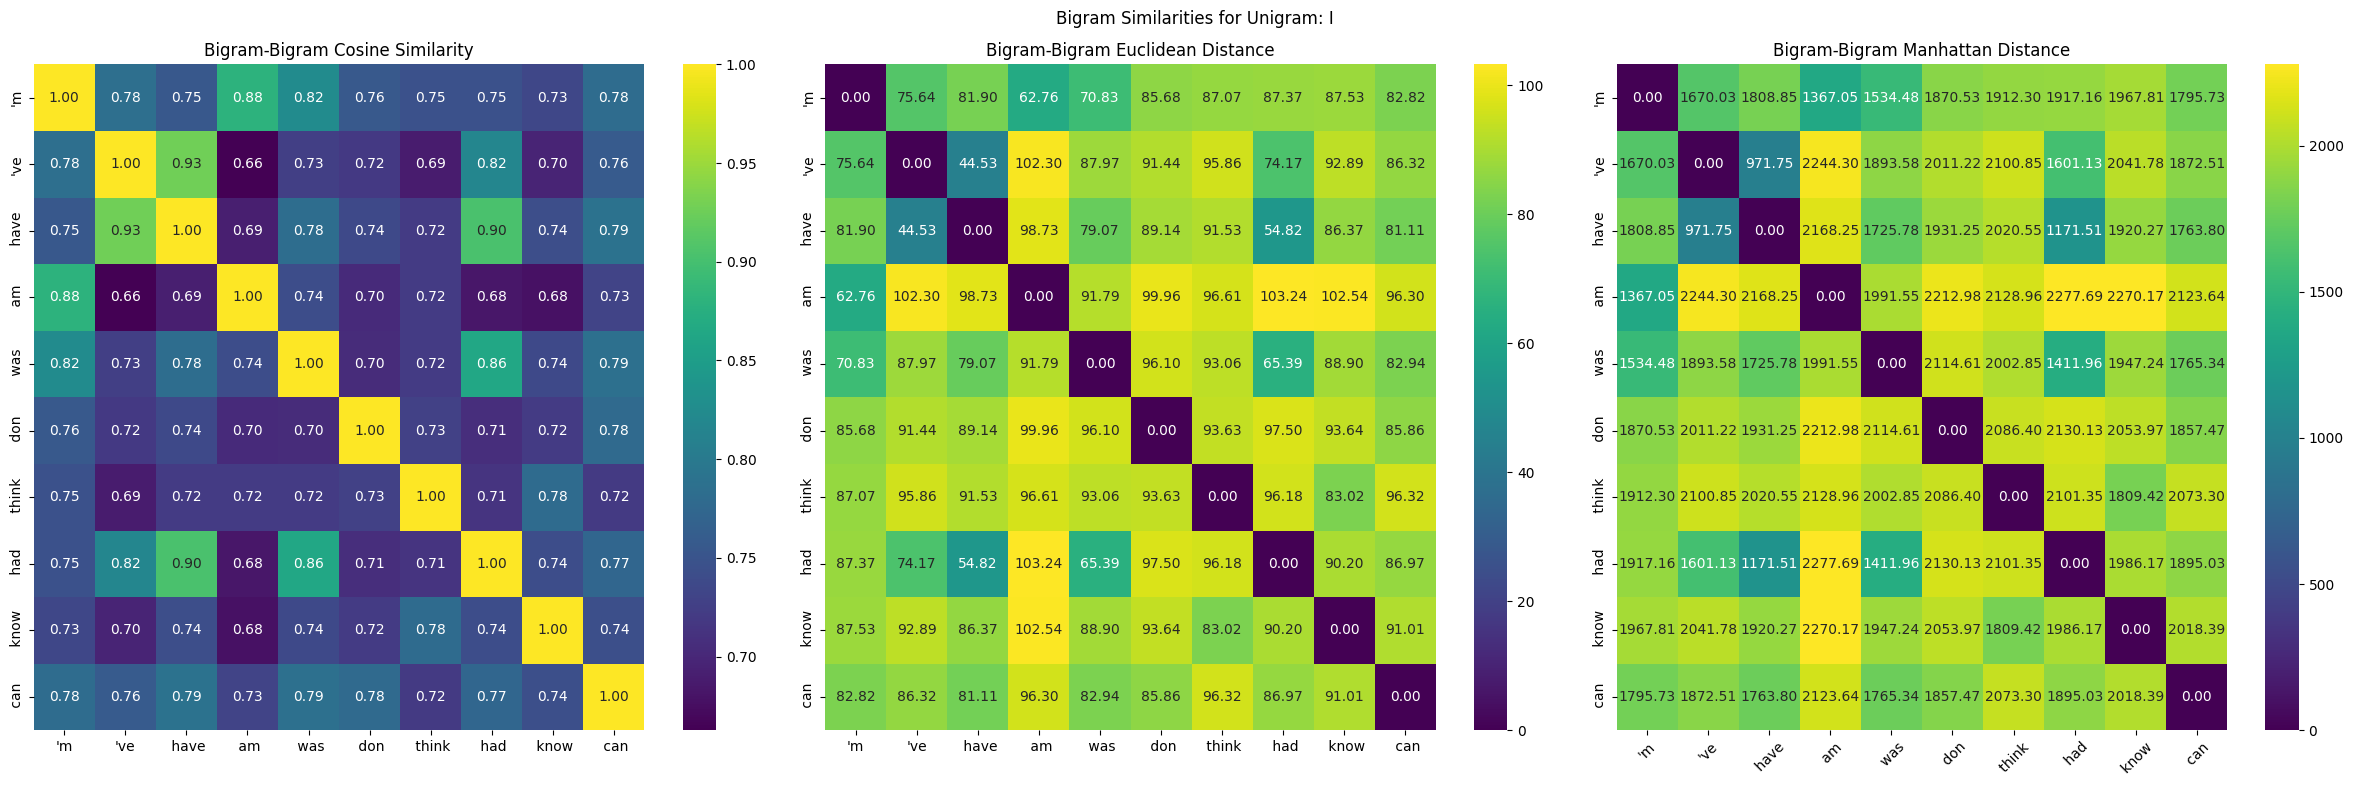

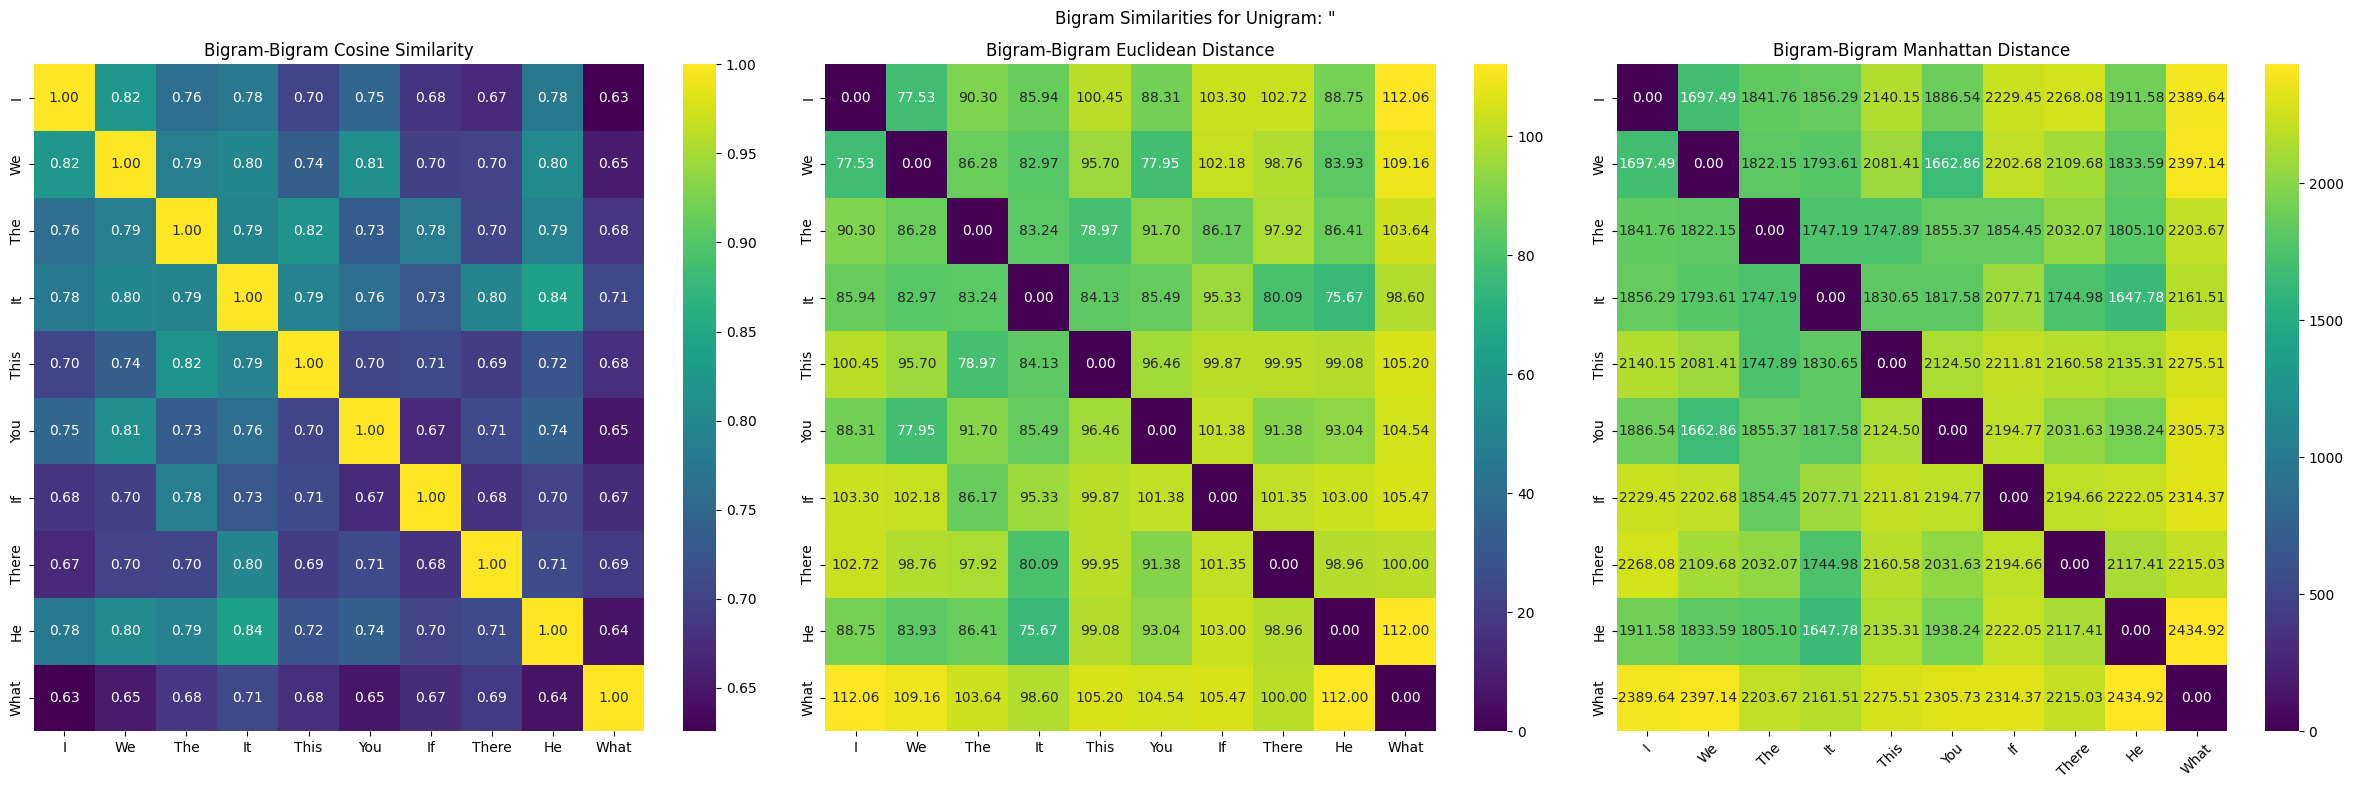

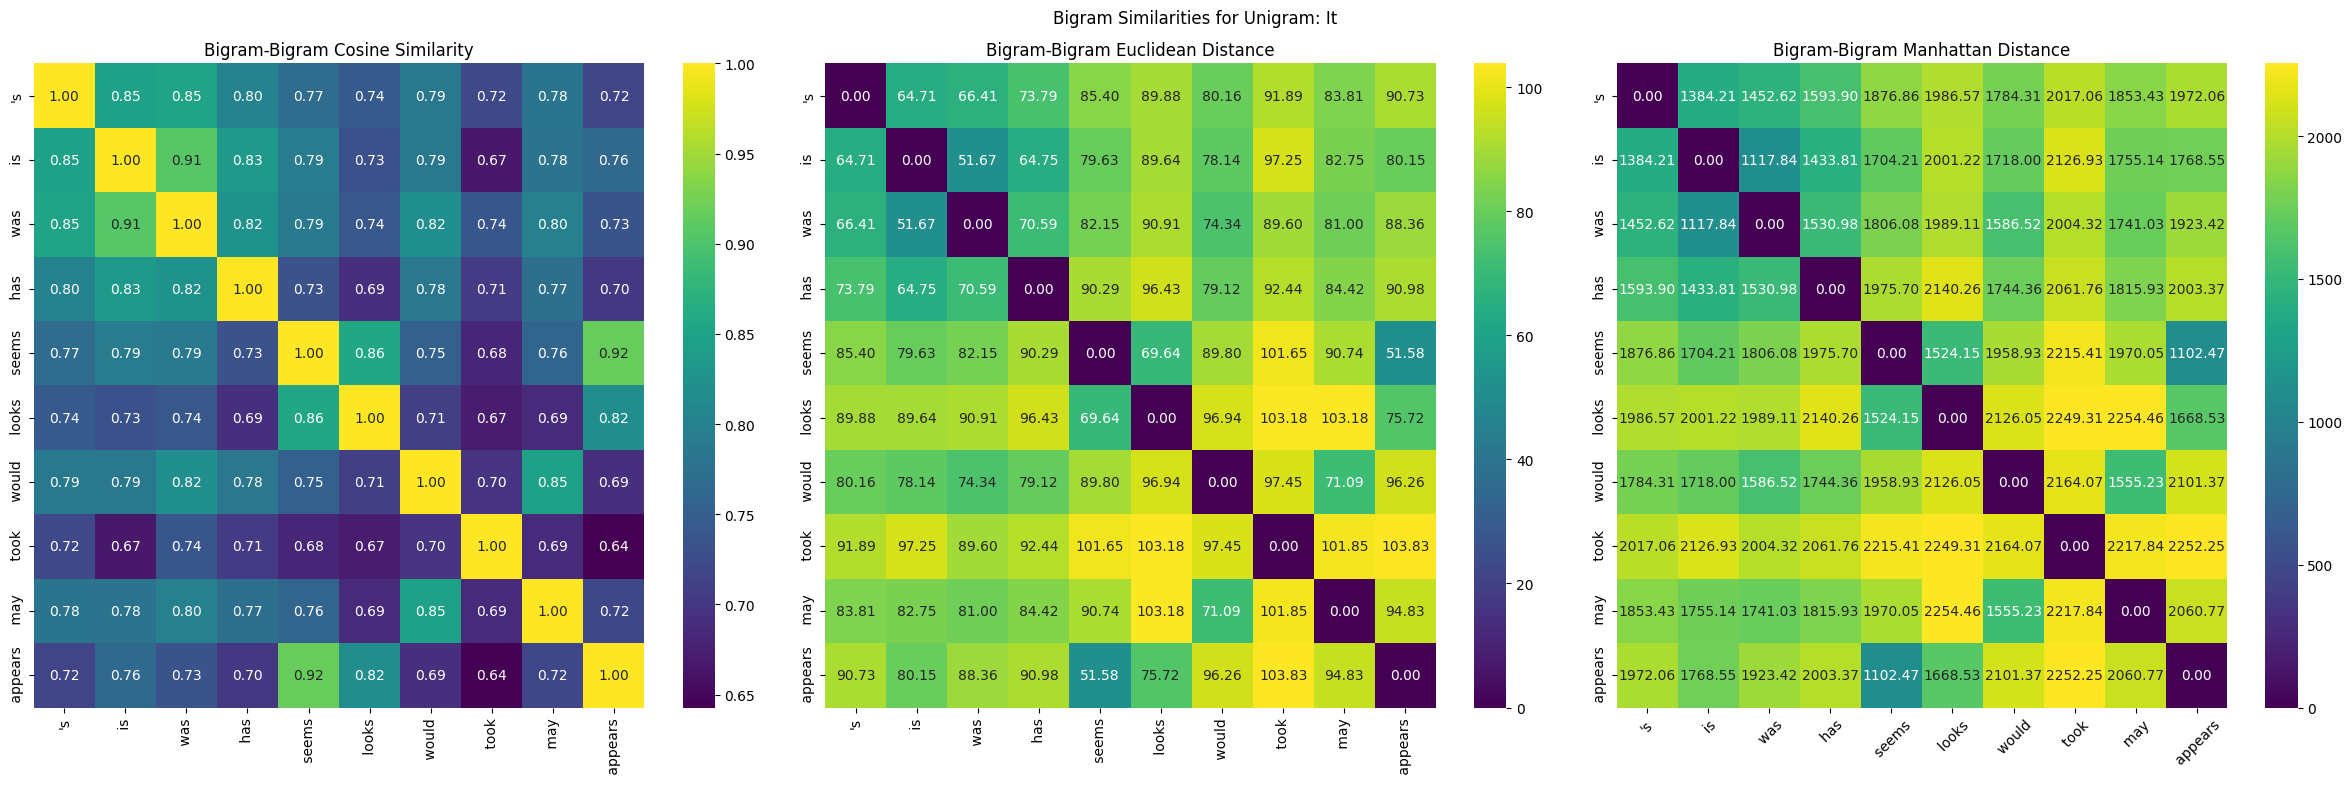

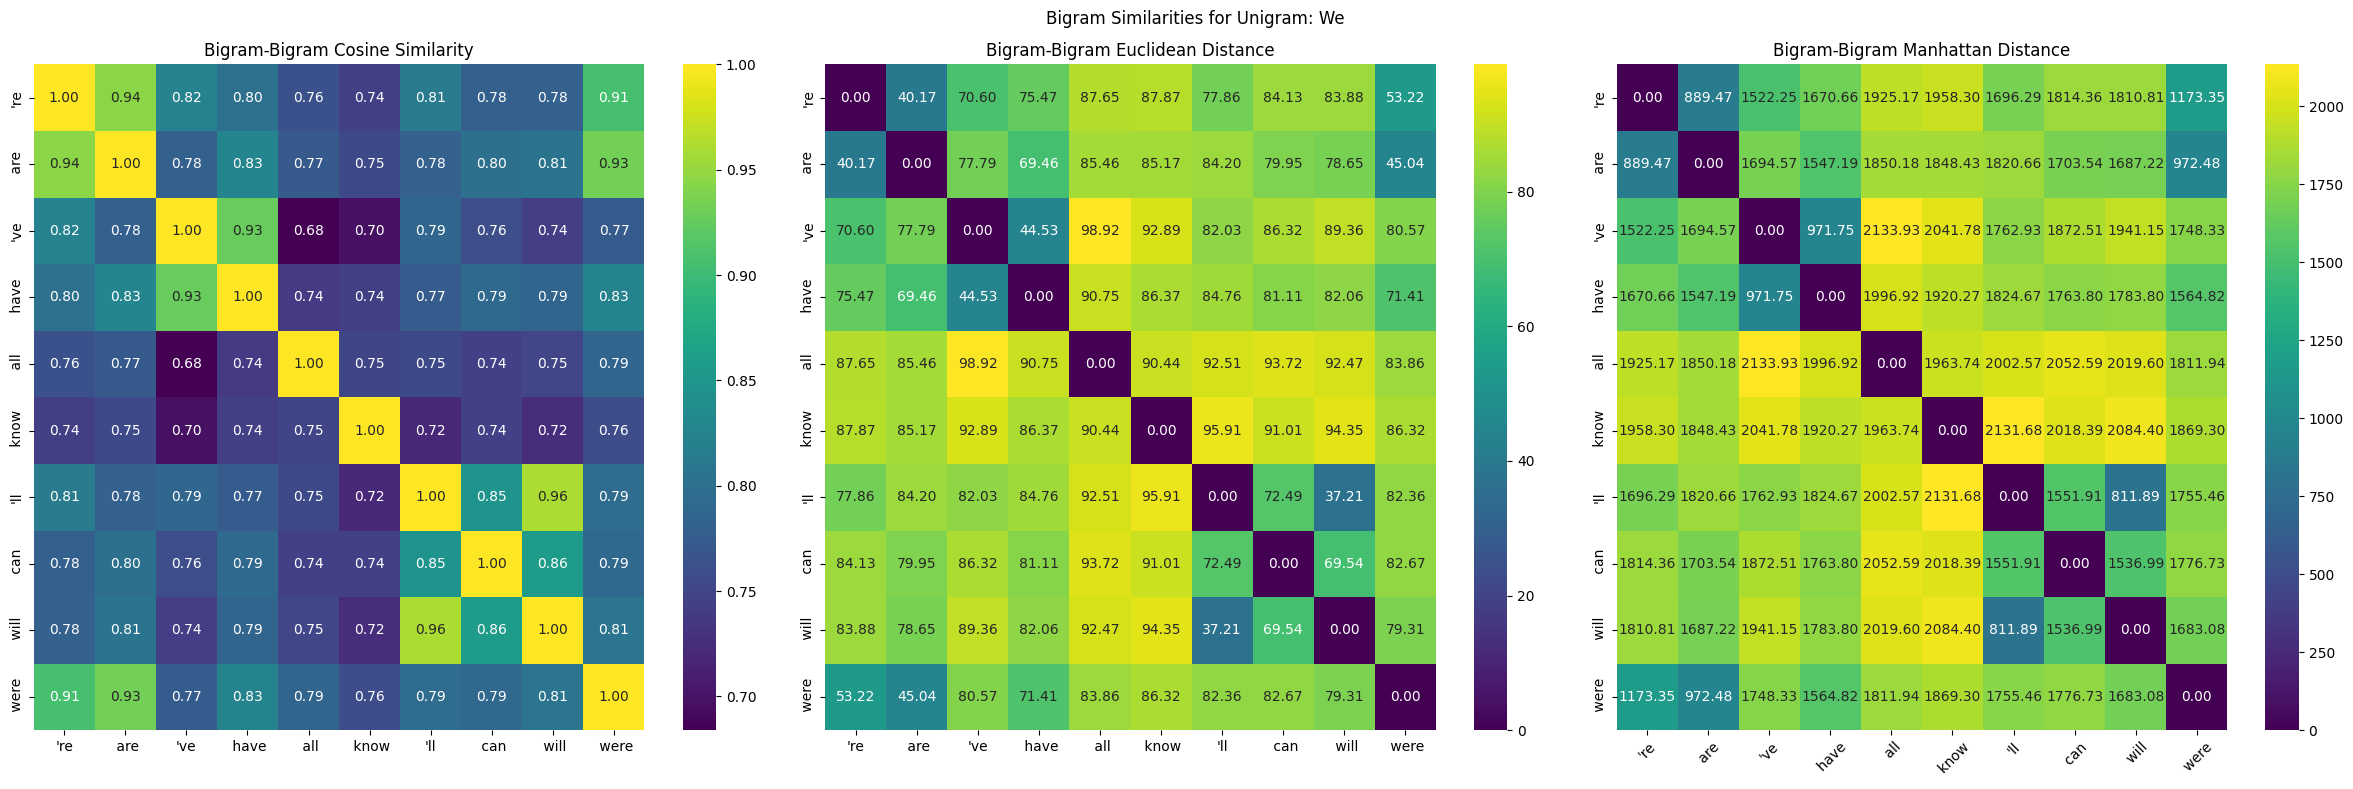

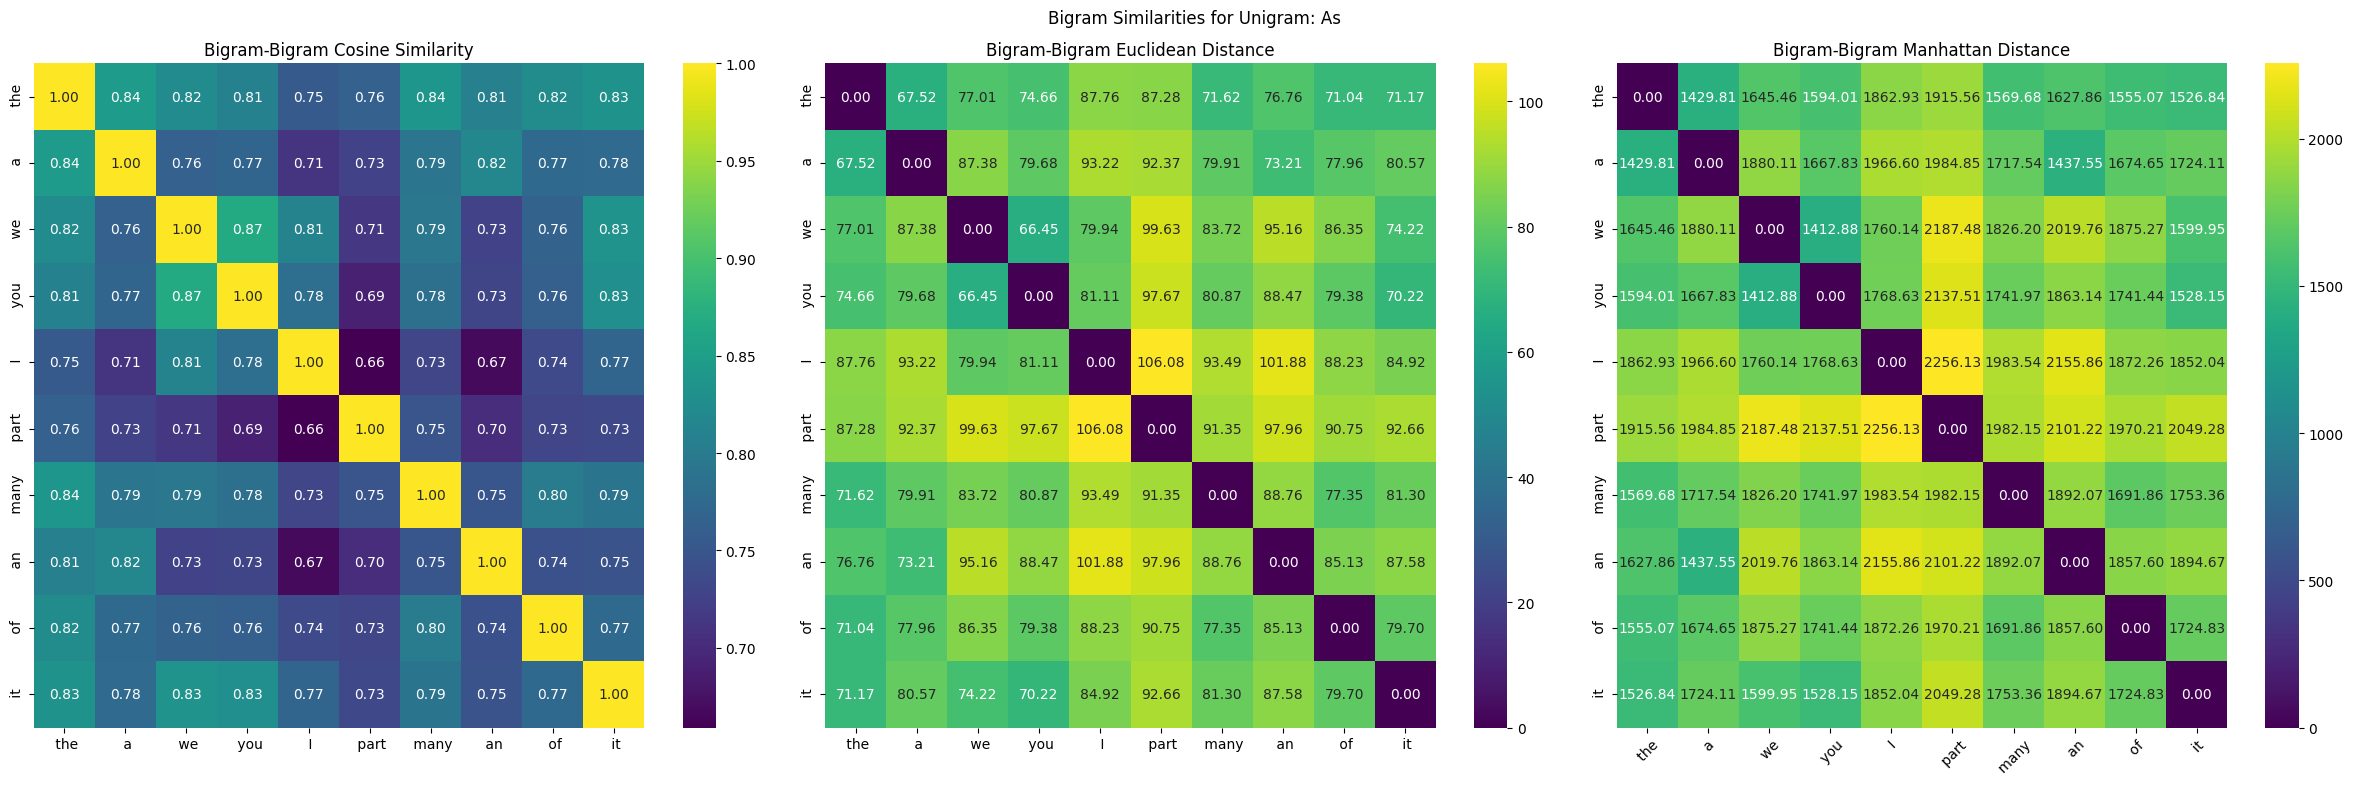

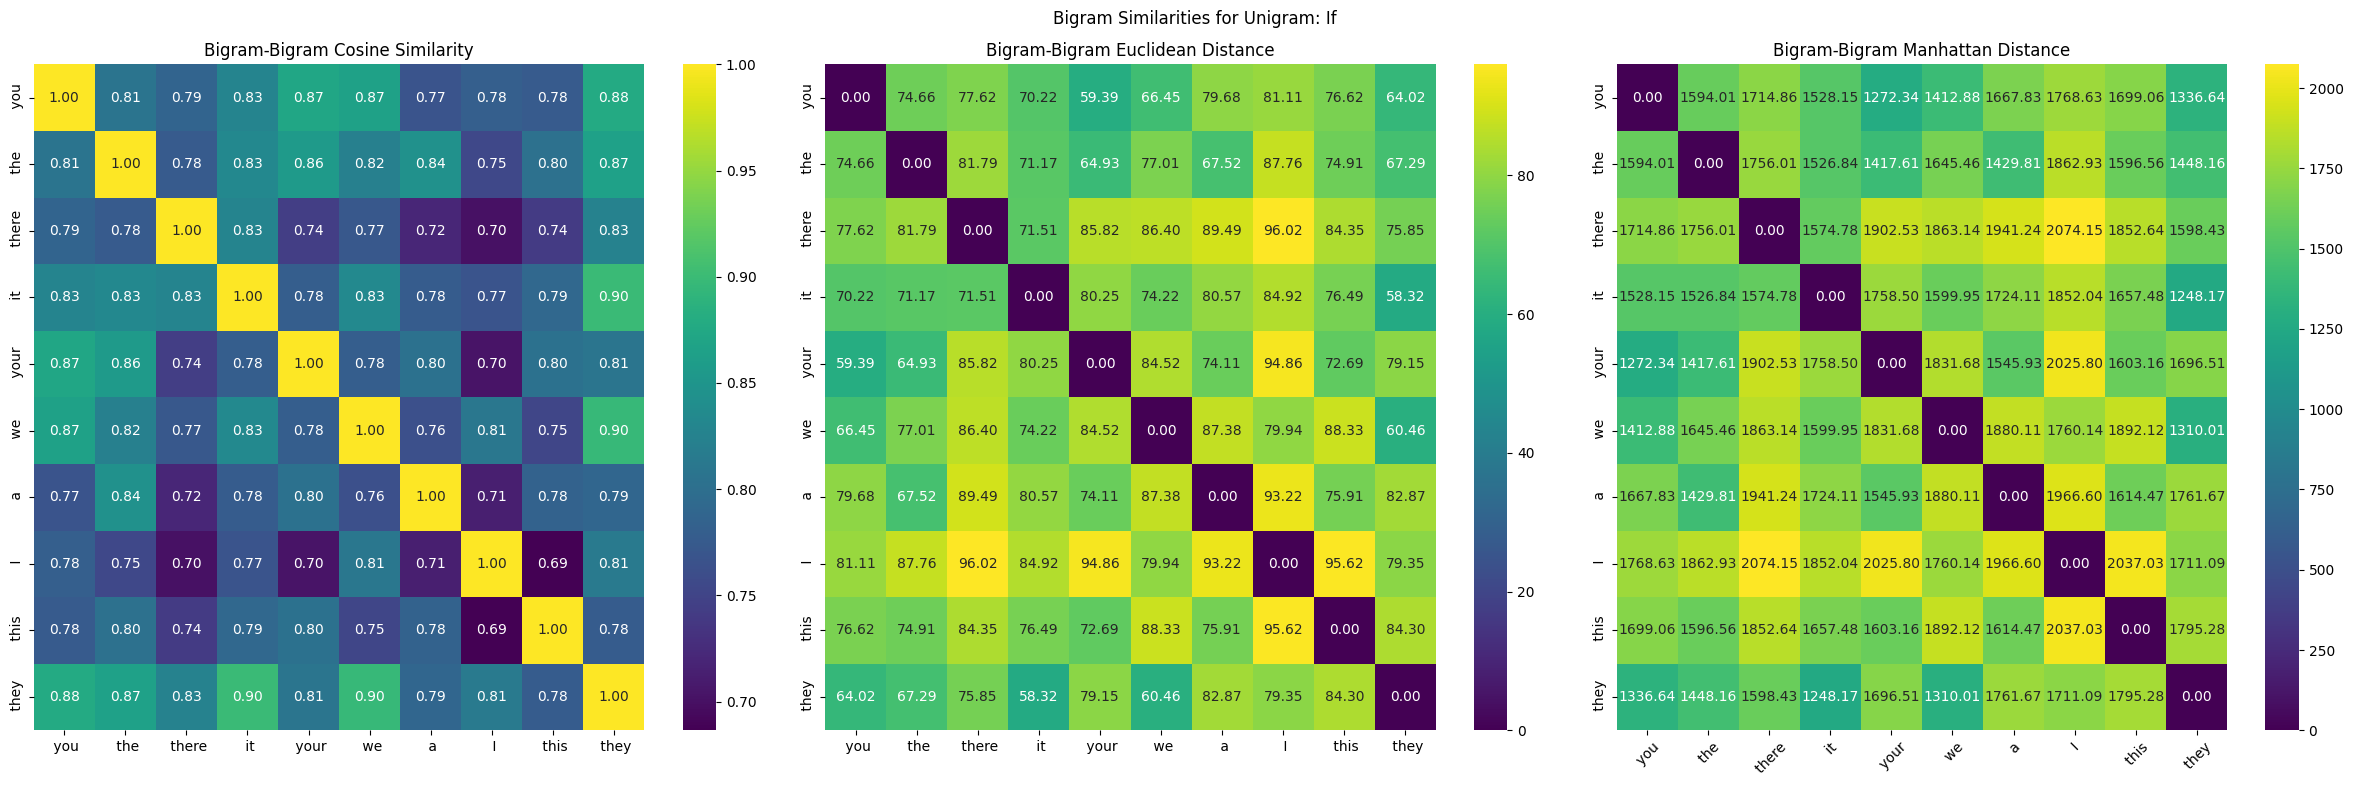

In [12]:
def main(prompt="<|endoftext|>", layer=8, top_k=10):
    # 1. Get top unigrams first
    print("\nGetting top unigrams...")
    unigram_predictions = get_top_predictions("<|endoftext|>", top_k)
    unigrams = [token for token, _ in unigram_predictions]
    unigram_embeddings = {token: get_embedding(token, layer) for token in unigrams}
    
    # 2. Get bigrams for each unigram
    print("\nGetting bigrams for each unigram...")
    bigram_dict = {}  # Structure: {unigram: [(bigram, prob), ...]}
    bigram_embeddings = {}
    for unigram in unigrams:
        bigram_predictions = get_top_predictions(unigram, top_k)
        bigram_dict[unigram] = bigram_predictions
        # Get embeddings for each bigram
        for bigram, _ in bigram_predictions:
            bigram_embeddings[bigram] = get_embedding(bigram, layer)
    
    # 3. Calculate similarities
    # a. Unigram-Unigram similarities
    unigram_similarities = {}
    for i, word1 in enumerate(unigrams):
        for j, word2 in enumerate(unigrams):
            embed1 = unigram_embeddings[word1]
            embed2 = unigram_embeddings[word2]
            unigram_similarities[(word1, word2)] = {
                'cosine': F.cosine_similarity(embed1, embed2, dim=-1).item(),
                'euclidean': torch.norm(embed1 - embed2, p=2).item(),
                'manhattan': torch.norm(embed1 - embed2, p=1).item()
            }
    
    # b. Unigram-Bigram similarities
    unigram_bigram_similarities = {}
    for unigram in unigrams:
        bigrams = [bigram for bigram, _ in bigram_dict[unigram]]
        for bigram in bigrams:
            embed1 = unigram_embeddings[unigram]
            embed2 = bigram_embeddings[bigram]
            unigram_bigram_similarities[(unigram, bigram)] = {
                'cosine': F.cosine_similarity(embed1, embed2, dim=-1).item(),
                'euclidean': torch.norm(embed1 - embed2, p=2).item(),
                'manhattan': torch.norm(embed1 - embed2, p=1).item()
            }
    
    # c. Bigram-Bigram similarities (between bigrams from same unigram)
    bigram_similarities = {}
    for unigram in unigrams:
        bigrams = [bigram for bigram, _ in bigram_dict[unigram]]
        for i, bigram1 in enumerate(bigrams):
            for j, bigram2 in enumerate(bigrams):
                embed1 = bigram_embeddings[bigram1]
                embed2 = bigram_embeddings[bigram2]
                bigram_similarities[(bigram1, bigram2)] = {
                    'cosine': F.cosine_similarity(embed1, embed2, dim=-1).item(),
                    'euclidean': torch.norm(embed1 - embed2, p=2).item(),
                    'manhattan': torch.norm(embed1 - embed2, p=1).item()
                }
    
    return {
        'unigrams': unigrams,
        'bigram_dict': bigram_dict,
        'unigram_embeddings': unigram_embeddings,
        'bigram_embeddings': bigram_embeddings,
        'unigram_similarities': unigram_similarities,
        'unigram_bigram_similarities': unigram_bigram_similarities,
        'bigram_similarities': bigram_similarities
    }

# Example usage and visualization
results = main("My name is Keegan and I like to eat tacos on Tuesdays.")

# Visualize unigram-unigram similarities
visualize_unigram_similarities(results['unigrams'], results['unigram_similarities'])
visualize_unigram_bigram_similarities(results)
visualize_bigram_similarities(results)

'''
Potential Metrics to Look Into:
1. Normalized Euclidean
2. Magnitude Ratio
3. Dot Product
4. Chebyshev Distance
5. Angular Distance
'''